# Eric Kofoid Assignment 5

In [2]:
library(fpp)

Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: fma
Loading required package: tseries
Loading required package: expsmooth
Loading required package: lmtest


# 1a)

* Mathematical Transformation - use this when the variation in seasons changes, when the YOY change gets bigger or smaller with each year.
* Calendar Transformation - use this when the monthly or weekly frequency don't have exact same number of days observed in each time-frame. Months don't have same number of days and weeks for a business don't always have same number of days (holidays).
* Population Transformation - use this when focusing in on geographical areas since the population in those areas changes over time. Comparing Kansas today to Kansas 50 years ago at a raw number will look drastically different, but looking at it from per capita (per 1000) will make it more consistent.
* Inflation Transformation - this one is pretty obvious. If you want to compare dollars today to dollars 10 years, have to adjust for inflation.

When dealing with a new data set, I always plot out the raw data first. Understand the base data too, what exactly is it measuring, is it measuring population or money (then probably could consider those types of Transformations). Is it varying YOY in the peaks/troughs.

# 1b)

Any time I will be using data about people over time, I would think that population transformation should be considered. Any time I use data that tracks sales over time, mathematical transformations might need to be considered. Of course if it is money over time, inflation transformation.

My "pigs" data that I have been using is monthly, so right off it is possible that calendar transformations may add value.

In the Aussie trinkets data from Assignment 3 makes perfect sense that we applied log (mathematical) transformation since the seasonal peaks had quite a bit of variation in them.

AirPassengers might have been able to have 2 different transformations. Mathematical because of the variation in the season values and Population because the US population increased over time as well.

# 2)

I want to predict the next 4 years of data from Air Passengers. The following are the steps I took to do this.

## Examining Data (EDA)

First step is to check if my data is stationary. Clearly there is trend and seasonality as seen in the decomposition of the data. This means the data is not stationary.

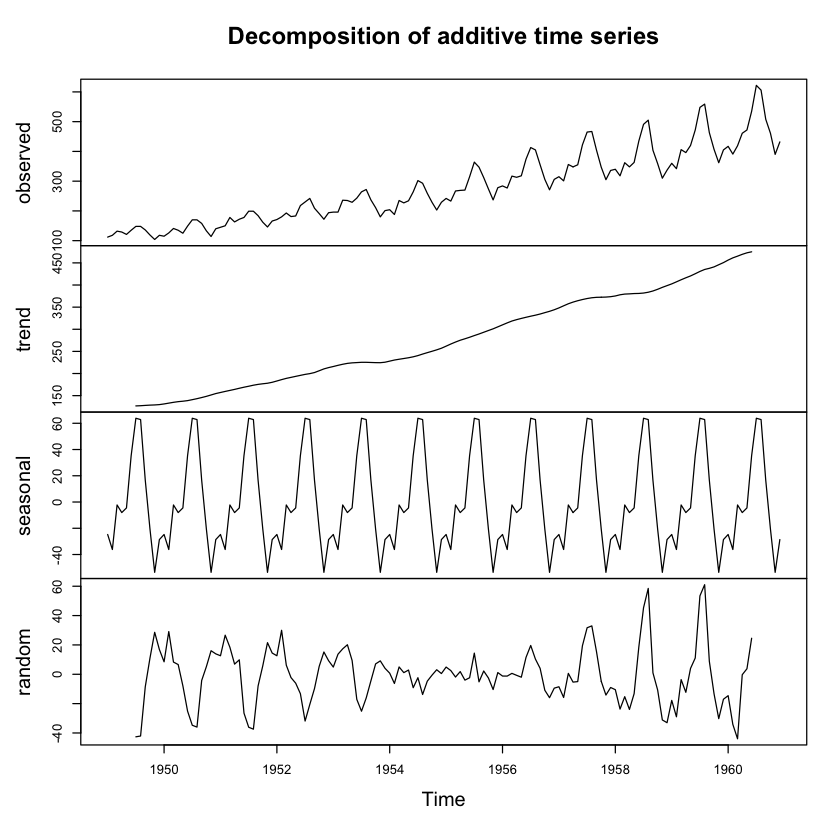

In [3]:
ap = AirPassengers
plot(decompose(ap))

## Dig little deeper (Transformation)

Since there seems to be seasonal variance, I think I may need to apply mathematical transformation here. The resulting data has less seasonal variance. This data will be easier to work with

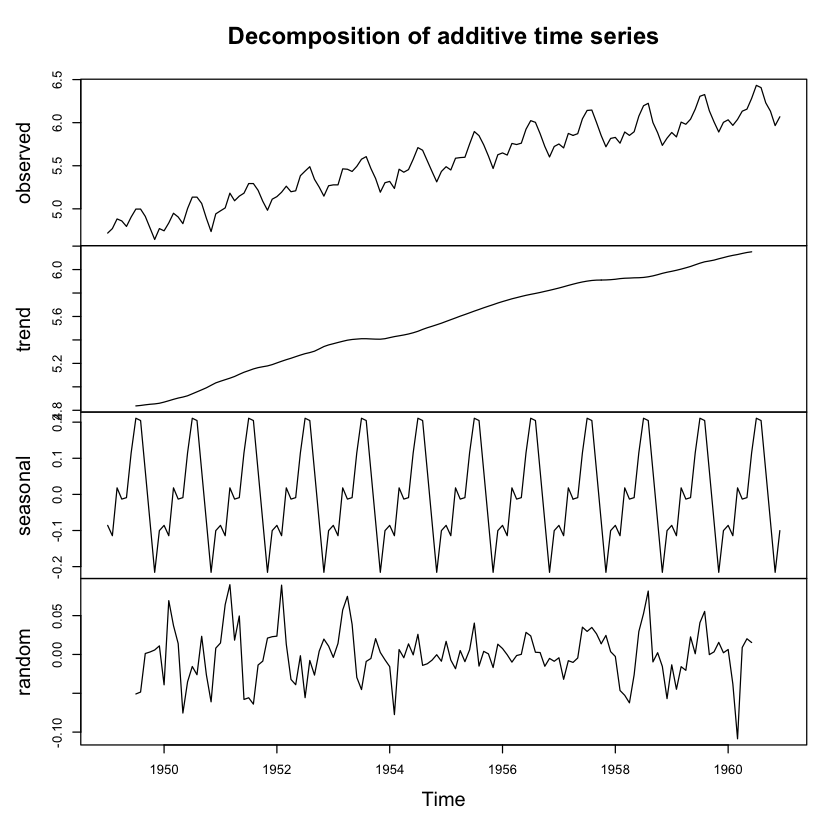

In [27]:
ap_log = log(ap)
plot(decompose(ap_log))

## Look at differencing (Stationarity)

Maybe differencing will help make the data stationary.

The plot of the diff seems to have mean around 0 and variance around 0. So this is possibly stationary

The DF test shows that with first order differencing we can reject the null hypo that the data is non-stationary. It has a statistically significant p-value < 0.05. So it seems d=1 in ARIMA model will help us.

Warning message in adf.test(ap_diff, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  ap_diff
Dickey-Fuller = -6.4313, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


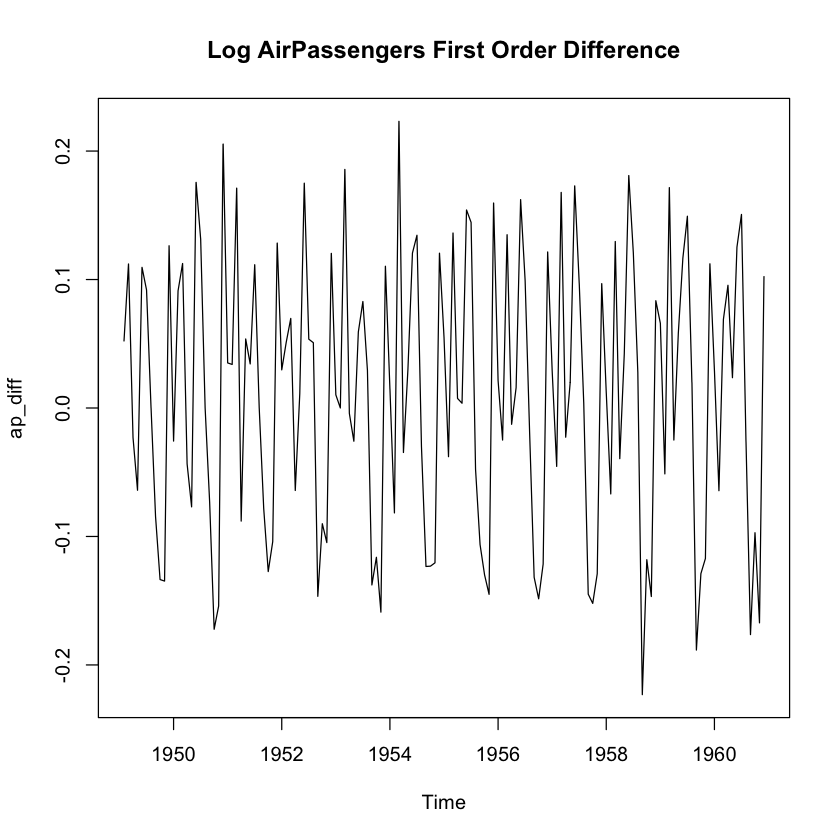

In [8]:
ap_diff = diff(ap_log)
plot(ap_diff, main="Log AirPassengers First Order Difference")
adf.test(ap_diff, alternative="stationary")

## What do ACF & PACF tell us about AR & MA

There is a significant spike in lag 12 of the ACF, but then there is also one at 24 & 36. The PACF is decaying quite a bit. So maybe this is AR(0) and MA(something).

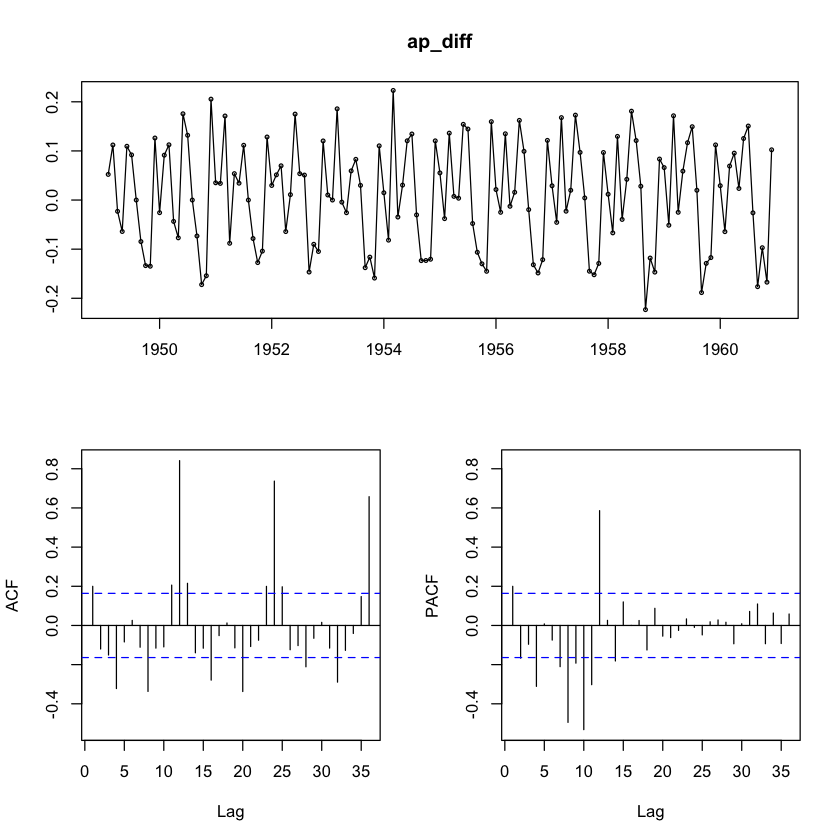

In [14]:
tsdisplay(ap_diff)

## Try Auto ARIMA

What does Auto ARIMA give me?

It tells me that I have a difference order of 1, which is what I expected. My guess that the AR(0) is also correct since the p = 0. What I don't understand as of yet is how the PACF I see above correlates to MA(1).

Non-Seasonal part:
* p = 0, 
* d = 1
* q = 1

And there is a Seasonal Component as well, which I knew there should be:
* p = 0
* d = 1
* q = 1

In [16]:
aa_fit = auto.arima(ap_log, approximation=FALSE, trace=FALSE)
summary(aa_fit)

Series: ap_log 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


## Check residuals

Lastly, I want to check the results to see if they are white noise. The ACF of the residuals shows that the lags are all within the bands of confidence meaning it looks like they are just white noise.

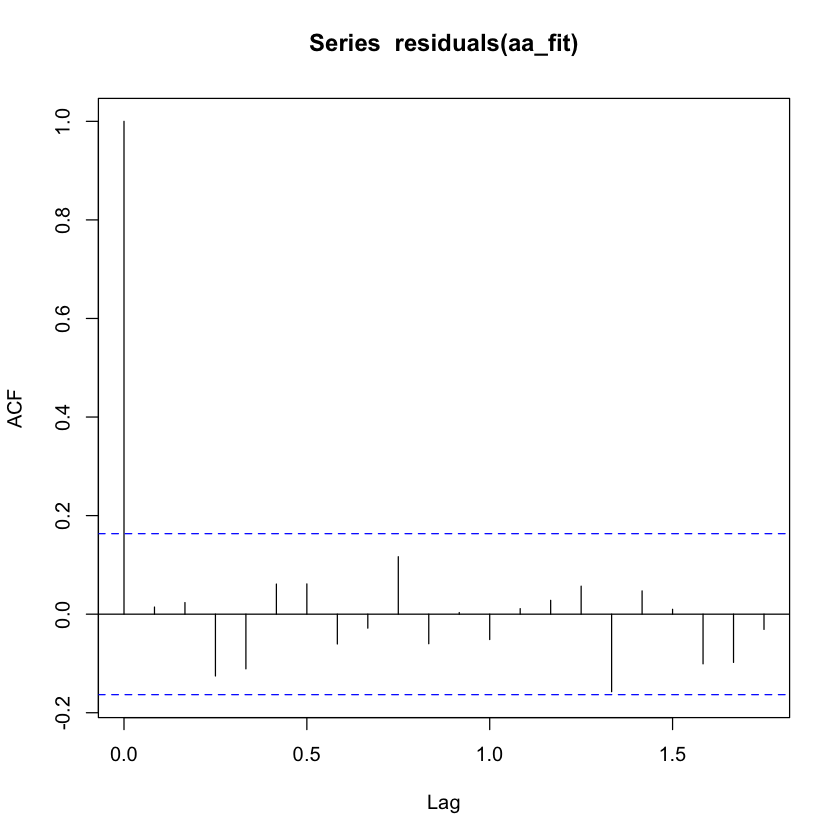

In [26]:
acf(residuals(aa_fit))

## Predict 4 years out

After all that I want to see my results. First, I need to revert the results back to real world numbers not the log.

The chart of the result looks good. It has the same seasonality and seasonal variance. The trend is upward and good. I think I have a winner here.

In [22]:
future_log = forecast(aa_fit, 48)
future_norm = future_log

# Convert Mean back
future_norm$mean = exp(future_log$mean)
# Convert Upper back
future_norm$upper = exp(future_log$upper)
# Convert Lower back
future_norm$lower = exp(future_log$lower)
# Convert Original ts back
future_norm$x=exp(future_log$x)

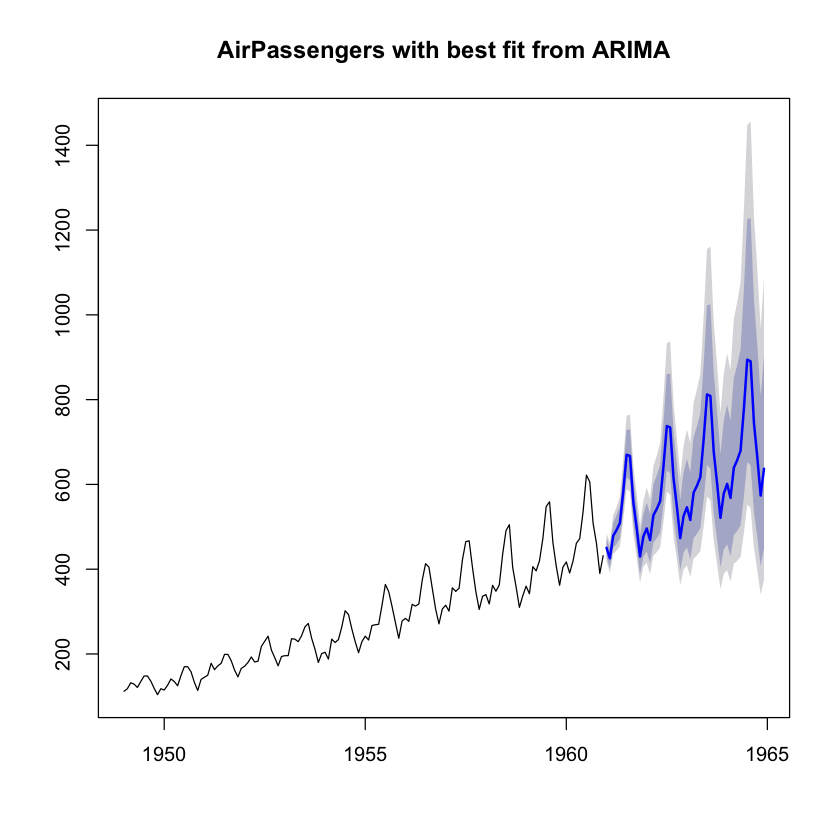

In [23]:
plot(future_norm, main="AirPassengers with best fit from ARIMA")